#Импорт библиотек

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.utils import img_to_array
from PIL import Image
from tensorflow.keras.losses import MeanAbsoluteError
import math
import numpy as np
from keras.optimizers import Adam

# Данные

In [ ]:
total = 11
image_cols = 160
image_rows = 176
data_path = '/content/drive/MyDrive/input/input_1'
mask_path = '/content/drive/MyDrive/input/mask'
smooth = 1.

In [ ]:
img_arr = list()
mask_arr = list()
for i in range(total):
  img = img_to_array(Image.open("/content/drive/MyDrive/input/input_1/input_{}.png".format(i+1)).convert("RGB").resize((image_rows, image_cols)))
  mask =  img_to_array(Image.open("/content/drive/MyDrive/input/mask/mask_{}.png".format(i+1)).convert("RGB").resize((image_rows, image_cols)))
  img_arr.append(img_to_array(img).reshape((image_rows, image_cols, 3)) / 255)
  mask_arr.append(img_to_array(mask).reshape((image_rows, image_cols, 3)) / 255)
img_arr = np.asarray(img_arr, dtype = np.float32)
mask_arr = np.asarray(mask_arr, dtype = np.float32)

##UNET

###Создание модели нейросети

In [ ]:
from keras import backend as K

K.set_image_data_format('channels_last')  # TF dimension ordering in this code

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
inputs = Input((image_rows, image_cols, 3))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_118 (Conv2D)            (None, 192, 192, 32  896         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_119 (Conv2D)            (None, 192, 192, 32  9248        ['conv2d_118[0][0]']             
                                )                                                           

##Обучение модели

In [ ]:
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

model.fit(img_arr, mask_arr, batch_size=32, epochs=10, verbose=1,
          validation_split=0.2,
          callbacks=[model_checkpoint])

Epoch 1/10
1/1 [==============================] - 13s 13s/step - loss: -0.5657 - dice_coef: 0.5657 - val_loss: -0.5776 - val_dice_coef: 0.5776
Epoch 2/10
1/1 [==============================] - 13s 13s/step - loss: -0.5658 - dice_coef: 0.5658 - val_loss: -0.5777 - val_dice_coef: 0.5777
Epoch 3/10
1/1 [==============================] - 10s 10s/step - loss: -0.5659 - dice_coef: 0.5659 - val_loss: -0.5778 - val_dice_coef: 0.5778
Epoch 4/10
1/1 [==============================] - 12s 12s/step - loss: -0.5660 - dice_coef: 0.5660 - val_loss: -0.5779 - val_dice_coef: 0.5779
Epoch 5/10
1/1 [==============================] - 12s 12s/step - loss: -0.5661 - dice_coef: 0.5661 - val_loss: -0.5780 - val_dice_coef: 0.5780
Epoch 6/10
1/1 [==============================] - 9s 9s/step - loss: -0.5662 - dice_coef: 0.5662 - val_loss: -0.5781 - val_dice_coef: 0.5781
Epoch 7/10
1/1 [==============================] - 11s 11s/step - loss: -0.5663 - dice_coef: 0.5663 - val_loss: -0.5782 - val_dice_coef: 0.5782
E

1/1 [==============================] - 0s 464ms/step


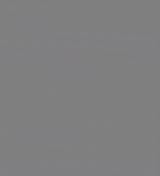

In [ ]:
out = model.predict(img_arr[0].reshape(1,176, 160, 3))
out = out * 255
out = out.astype(np.uint8)
Image.fromarray(out.reshape(176, 160, 3))